In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# from utils import *
# from usad import *

## Utils


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import roc_curve,roc_auc_score

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_history(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()

def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

def confusion_matrix(target, predicted, perc=False):

    data = {'y_Actual':    target,
            'y_Predicted': predicted
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])

    if perc:
        sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

## USAD model

In [ ]:
import torch
import torch.nn as nn

# from utils import *
device = get_default_device()

class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)

  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z

class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w

class UsadModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder1 = Decoder(z_size, w_size)
    self.decoder2 = Decoder(z_size, w_size)

  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    with torch.no_grad():
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}

  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        print(f'Epoch ', epoch)
        for [batch] in train_loader:
            batch=to_device(batch,device)

            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()


            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()


        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for [batch] in test_loader:
            batch=to_device(batch,device)
            w1=model.decoder1(model.encoder(batch))
            w2=model.decoder2(model.encoder(w1))
            results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

## Normal

In [ ]:
normal = pd.read_csv("/content/Normal.csv", nrows=10000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

(10000, 51)

In [ ]:
threshold_cusum = 3 * np.std(normal)
threshold_cusum

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,0
FIT101,3.160443
LIT101,219.143448
MV101,1.257990
P101,1.292566
P102,0.000000
AIT201,16.867938
AIT202,0.592773
AIT203,222.841800
FIT201,3.191793
MV201,1.256876


In [ ]:
# Transform all columns into float64
for i in list(normal):
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)
normal

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,2.470294,261.5804,2.0,2.0,1.0,244.3284,8.190080,306.1010,2.471278,2.0,...,0.000000,1.0,1.0,10.02948,0.000000,4.277749,0.000256,1.0,1.0,1.0
1,2.457163,261.1879,2.0,2.0,1.0,244.3284,8.190080,306.1010,2.468587,2.0,...,0.000000,1.0,1.0,10.02948,0.000000,4.277749,0.000256,1.0,1.0,1.0
2,2.439548,260.9131,2.0,2.0,1.0,244.3284,8.190080,306.1010,2.467305,2.0,...,0.000000,1.0,1.0,10.02948,0.000000,4.277749,0.000256,1.0,1.0,1.0
3,2.428338,260.2850,2.0,2.0,1.0,244.3284,8.190080,306.1010,2.466536,2.0,...,0.000000,1.0,1.0,10.02948,0.000000,4.277749,0.000256,1.0,1.0,1.0
4,2.424815,259.8925,2.0,2.0,1.0,244.4245,8.190080,306.1010,2.466536,2.0,...,0.000000,1.0,1.0,10.02948,0.000000,4.277749,0.000256,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.498479,338.6728,2.0,2.0,1.0,263.4901,8.600872,520.2769,2.472175,2.0,...,0.310604,2.0,1.0,253.18830,1.521802,192.402600,0.000128,1.0,1.0,1.0
9996,2.487269,338.2803,2.0,2.0,1.0,263.4901,8.587414,520.2769,2.471663,2.0,...,0.310604,2.0,1.0,253.18830,1.521802,192.402600,0.000128,1.0,1.0,1.0
9997,2.474458,337.9662,2.0,2.0,1.0,263.4901,8.569469,520.5076,2.471663,2.0,...,0.310604,2.0,1.0,253.18830,1.521802,192.402600,0.000128,1.0,1.0,1.0
9998,2.456843,337.4167,2.0,2.0,1.0,263.4901,8.556011,520.5332,2.471663,2.0,...,0.310604,2.0,1.0,253.18830,1.521802,192.402600,0.000128,1.0,1.0,1.0


In [ ]:
normal.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [ ]:
# @title One Hot Encoding and Scaling - saving encoder and scaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import joblib

data = normal.copy()

# Define the categorical columns and their possible values
categorical_columns = ['P601', 'P602', 'P603']
categories = [list(range(3))] * len(categorical_columns)  # Values 0, 1, 2 for all columns

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop=None, categories=categories)
encoded_features = encoder.fit_transform(data[categorical_columns])

# Convert encoded features to a DataFrame
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

# Save the OneHotEncoder for future use
joblib.dump(encoder, "onehot_encoder.pkl")

# Drop the original categorical columns and concatenate the encoded columns
data = pd.concat([data.drop(columns=categorical_columns), encoded_df], axis=1)

# Separate the non-categorical columns
non_categorical_columns = [col for col in data.columns if col not in encoded_feature_names]

# Scale only the non-categorical columns
scaler = MinMaxScaler()
scaled_non_categorical = scaler.fit_transform(data[non_categorical_columns])

# Convert scaled data back to a DataFrame
scaled_non_categorical_df = pd.DataFrame(scaled_non_categorical, columns=non_categorical_columns, index=data.index)

# Combine the scaled non-categorical columns with the encoded categorical columns
final_data = pd.concat([scaled_non_categorical_df, encoded_df], axis=1)

# Save the MinMaxScaler for future use
joblib.dump(scaler, "minmax_scaler.pkl")

# Display the result
print("Encoded and Scaled Data:")
print(final_data)


Encoded and Scaled Data:
        FIT101    LIT101  MV101  P101  P102    AIT201    AIT202    AIT203  \
0     0.917886  0.160292    1.0   1.0   0.0  0.000000  0.000000  0.023824   
1     0.913007  0.159845    1.0   1.0   0.0  0.000000  0.000000  0.023824   
2     0.906462  0.159533    1.0   1.0   0.0  0.000000  0.000000  0.023824   
3     0.902297  0.158819    1.0   1.0   0.0  0.000000  0.000000  0.023824   
4     0.900988  0.158372    1.0   1.0   0.0  0.004366  0.000000  0.023824   
...        ...       ...    ...   ...   ...       ...       ...       ...   
9995  0.928359  0.247959    1.0   1.0   0.0  0.870452  0.552348  0.994771   
9996  0.924194  0.247512    1.0   1.0   0.0  0.870452  0.534252  0.994771   
9997  0.919434  0.247155    1.0   1.0   0.0  0.870452  0.510123  0.995817   
9998  0.912888  0.246530    1.0   1.0   0.0  0.870452  0.492028  0.995933   
9999  0.907890  0.246307    1.0   1.0   0.0  0.870452  0.479964  0.995933   

        FIT201  MV201  ...    FIT601  P601_0.0  P6

In [ ]:
scaled_df['P603_1.0'].value_counts()

,count
P603_1.0,
0.0,10000


In [ ]:
from sklearn import preprocessing
import joblib

min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

joblib.dump(min_max_scaler, "minmax_scaler.pkl")


['minmax_scaler.pkl']

## Attack

In [ ]:
attack = pd.read_csv("/content/Attack.csv")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

(177108, 51)

In [ ]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [ ]:
from sklearn import preprocessing

x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

attack.head(2)


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.901821,0.457396,1.0,1.0,0.0,0.803493,0.25853,0.104221,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000074,0.0,0.0,0.0
1,0.908961,0.457440,1.0,1.0,0.0,0.803493,0.25853,0.104221,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000074,0.0,0.0,0.0


## Windows

In [ ]:
import numpy as np


In [ ]:
window_size=10


In [ ]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(63681, 10, 51)

In [ ]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(79704, 10, 51)

# Training


In [ ]:
import torch.utils.data as data_utils

BATCH_SIZE = 100
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(2,model,train_loader,val_loader)

Epoch  0
Epoch [0], val_loss1: 0.0247, val_loss2: 0.0256
Epoch  1
Epoch [1], val_loss1: 0.0202, val_loss2: -0.0016


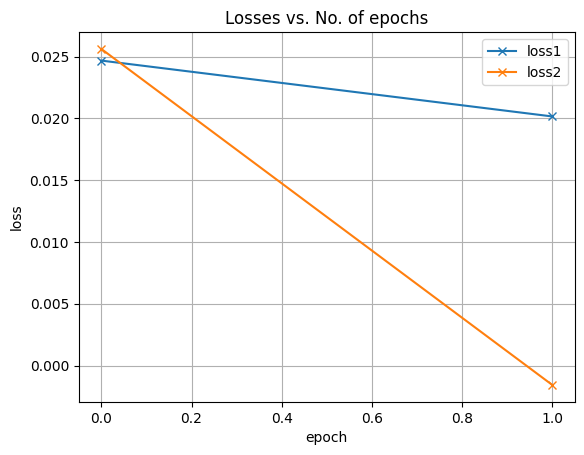

In [ ]:
plot_history(history)


In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

model.eval()


UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=510, out_features=255, bias=True)
    (linear2): Linear(in_features=255, out_features=127, bias=True)
    (linear3): Linear(in_features=127, out_features=1000, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=1000, out_features=127, bias=True)
    (linear2): Linear(in_features=127, out_features=255, bias=True)
    (linear3): Linear(in_features=255, out_features=510, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=1000, out_features=127, bias=True)
    (linear2): Linear(in_features=127, out_features=255, bias=True)
    (linear3): Linear(in_features=255, out_features=510, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)

## Saving to ONNX

In [ ]:
!pip install onnxruntime
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.5 MB/s eta 0:00:00


In [ ]:
# Ensure the device is set to the same device as the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the same device as the input
model.to(device)

# Generate dummy input on the same device as the model
dummy_input = torch.randn(1, w_size).to(device)  # Adjust w_size as needed

# Export the encoder to ONNX
torch.onnx.export(
    model.encoder,
    dummy_input,
    "usad_encoder.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder1,
    torch.randn(1, 1000).to(device),
    "usad_decoder1.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)

# Export the encoder to ONNX
torch.onnx.export(
    model.decoder2,
    torch.randn(1, 1000).to(device),
    "usad_decoder2.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['latent'],
    dynamic_axes={'input': {0: 'batch_size'}, 'latent': {0: 'batch_size'}}
)


In [ ]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<ipython-input-22-6ed220ec2271>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model.pth")


<All keys matched successfully>

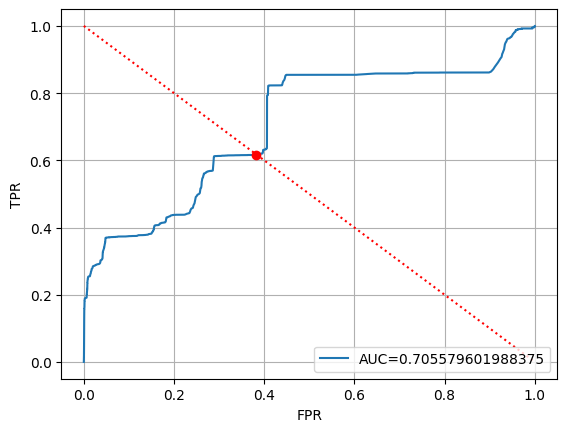

In [ ]:
results=testing(model,test_loader)
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

threshold=ROC(y_test,y_pred)
